In [1]:
# basic functions
import os
import sys
import math
import numpy as np
import random
import argparse
import shutil
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from model_nets import *
from sdr_family import *

C:\Users\zhengsiming\.conda\envs\newenvwithlowTO\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\zhengsiming\.conda\envs\newenvwithlowTO\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

In [2]:
def train(trainLoader, trainLoader_cor, R_net, D_net, Q_net, optimizer_R, optimizer_D, optimizer_Q, device):
    """
    Training procedure for representation learning.
    Args:
        trainLoader, trainLoader_cor (DataLoader): Two DataLoader objects.
        R_net, D_net, Q_net (nn.Module): Three nn.Module objects for representer, MI-Discriminator, and
                                         Push-Discriminator in device.
        optimizer_R, optimizer_D, optimizer_Q (torch.optim): The corresponding optimizers.
        device: Computation device: CPU or GPU
    """
    R_net.train()
    D_net.train()
    Q_net.train()
    for batch_idx, (y_data, x_data, u_data) in enumerate(trainLoader):
        x_data = Variable(x_data.to(device))
        y_data = Variable(y_data.to(device))
        u_data = Variable(u_data.to(device))
        
        # Discriminator forward-loss-backward-update
        laten_r = R_net(x_data)
        new_laten_r = Variable(laten_r.clone())
        
        # MI-Discriminator forward-loss-backward-update
        index = torch.randperm(x_data.shape[0])
        permuted_y_data = y_data[index,:]
#         print(permuted_y_data.is_cuda)
        optimizer_D.zero_grad()
        D_loss = torch.mean(torch.exp(D_net(new_laten_r, permuted_y_data))) - torch.mean(D_net(new_laten_r, y_data))
        D_loss.backward()
        optimizer_D.step()
        
        # Push-Discriminator forward-loss-backward-update
        optimizer_Q.zero_grad()
        Q_loss = torch.mean(torch.exp(Q_net(u_data))) - torch.mean(Q_net(new_laten_r))
        Q_loss.backward()
        optimizer_Q.step()
        
        # Representer forward-loss-backward-update
        optimizer_R.zero_grad()
        
        R_loss = (torch.mean(torch.exp(D_net(R_net(x_data), permuted_y_data))) - 
                  torch.mean(D_net(R_net(x_data), y_data)))-2*(torch.mean(torch.exp(Q_net(u_data))) 
                                                             - torch.mean(Q_net(R_net(x_data))))
        R_loss.backward()
        optimizer_R.step()
    Y, X, U = next(iter(trainLoader_cor))
    Y = Y.to(device)
    X = X.to(device)
    U = U.to(device)
    index = torch.randperm(X.shape[0])
    D_training_error = torch.mean(torch.exp(D_net(R_net(X), Y[index,:]))) - torch.mean(D_net(R_net(X), Y))
    Q_training_error = torch.mean(Q_net(R_net(X))) - torch.mean(torch.exp(Q_net(U)))
    R_training_error = D_training_error + Q_training_error
    return R_training_error.cpu().detach().numpy().item(),D_training_error.cpu().detach().numpy().item(),Q_training_error.cpu().detach().numpy().item()

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument('--batchSz', type=int, default=512, help='mini batch size')
parser.add_argument('--latent_dim', type=int, default=2, help='the dimension of latent space')
parser.add_argument('--nEpochs', type=int, default=1000, help='the number of outer loop')
parser.add_argument('--cuda_device', type=int, default=0, help='choose cuda device')
parser.add_argument('--no-cuda', action='store_true', help='if TRUE, cuda will not be used')
parser.add_argument('--save', help='path to save results')
parser.add_argument('--seed', type=int, default=1, help='random seed')
parser.add_argument('--model', type=int, default=2, help='1: Model A; 2: Model B')
parser.add_argument('--lr', type=float, default=1e-3)
args = parser.parse_args(args=['--cuda_device', '0','--batchSz','512','--nEpochs','5000','--model','1','--seed','13'])
print(args)
args.cuda = not args.no_cuda and torch.cuda.is_available()
print(args.cuda)
device = torch.device("cuda" if args.cuda else "cpu")
args.save = args.save or 'toy_sim/toy_reg'
cuda_indicator = not args.no_cuda and torch.cuda.is_available()
setup_seed(1234, cuda_indicator)

if not os.path.exists(args.save):
    os.makedirs(args.save, exist_ok=True)

device = torch.device("cuda" if args.cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_n = 4000
validation_n = 1000
test_n = 1000
n_sample = train_n + validation_n + test_n

p = 10
X = np.random.randn(n_sample, p)
b1 = np.random.randn(p, 1)
b2 = np.random.randn(p, 1)
b1 = np.random.randn(p, 1)/np.linalg.norm(b1)
b2 = np.random.randn(p, 1)/np.linalg.norm(b2)
c = 5
truth1 = np.sin(np.pi *np.dot(X, b1)/2)
truth2 = np.sin(np.pi *np.dot(X, b2)/2)
sigma=0.25
eps1 = sigma*np.random.randn(n_sample, 1)
eps2 = sigma*np.random.randn(n_sample, 1)
y = np.sign(2*truth1+eps1)*np.log(np.abs(truth2+ c + eps2))

truth = np.concatenate((truth1, truth2), axis=1)
truth = truth.astype(np.float32)
X = X.astype(np.float32)
y = y.astype(np.float32)

x_dim = X.shape[1]
y_dim = y.shape[1]
u_dim = args.latent_dim

Namespace(batchSz=512, cuda_device=0, latent_dim=2, lr=0.001, model=1, nEpochs=5000, no_cuda=False, save=None, seed=13)
False


In [24]:
ind = np.arange(n_sample)
np.random.shuffle(ind)
X_train_val, X_test = X[ind[:train_n + validation_n],], X[ind[train_n + validation_n:],]
y_train_val, y_test = y[ind[:train_n + validation_n],], y[ind[train_n + validation_n:],]
truth_train_val, truth_test = truth[ind[:train_n + validation_n],], truth[ind[train_n + validation_n:],]
ind = np.arange(train_n + validation_n)
np.random.shuffle(ind)
X_train, X_validation = X_train_val[ind[0:train_n]], X_train_val[ind[train_n:]]
y_train, y_validation = y_train_val[ind[0:train_n]], y_train_val[ind[train_n:]]
truth_train, truth_validation = truth_train_val[ind[0:train_n]], truth_train_val[ind[train_n:]]
U_train_X = np.random.randn(train_n, 2)
U_train = np.sin(np.pi * U_train_X/2)
U_validation_X = np.random.randn(validation_n, 2)
U_validation = np.sin(np.pi * U_validation_X/2)
U_test_X = np.random.randn(test_n, 2)
U_test = np.sin(np.pi * U_test_X/2)

train_dat = TensorDataset(torch.from_numpy(y_train), torch.from_numpy(X_train).float(), torch.from_numpy(U_train).float())
trainLoader = DataLoader(train_dat, batch_size=args.batchSz, shuffle=True)
trainLoader_cor = DataLoader(train_dat, batch_size=len(train_dat), shuffle=False)

validation_dat = TensorDataset(torch.from_numpy(truth_validation), torch.from_numpy(X_validation).float(), torch.from_numpy(U_validation).float())
validationLoader = DataLoader(validation_dat, batch_size=len(validation_dat), shuffle=False)

test_dat = TensorDataset(torch.from_numpy(truth_test), torch.from_numpy(X_test).float(), torch.from_numpy(U_test).float())
testLoader = DataLoader(test_dat, batch_size=args.batchSz, shuffle=False)
testLoader_cor = DataLoader(test_dat, batch_size=len(test_dat), shuffle=False)

In [26]:
mylr = 1e-3
D_net = MIDiscriminator(u_dim, y_dim)
Q_net = PushDiscriminator(u_dim)
R_width_vec = [x_dim, 64, 64,u_dim]        
R_net = Representer(x_dim, u_dim, R_width_vec)
D_width_vec = [u_dim + y_dim, 32, 32] 
D_net = MIDiscriminator(u_dim, y_dim, D_width_vec)
Q_width_vec = [u_dim, 32, 32] 
Q_net = PushDiscriminator(u_dim, Q_width_vec)

In [27]:
args.nEpochs = 3000

In [28]:
print('  + Number of params (Rnet) : {}'.format(
    sum([p.data.nelement() for p in R_net.parameters()])))
print('  + Number of params (Dnet) : {}'.format(
    sum([p.data.nelement() for p in D_net.parameters()])))
print('  + Number of params (Qnet) : {}'.format(
    sum([p.data.nelement() for p in Q_net.parameters()])))
setup_seed(42, cuda_indicator)
R_net.apply(weight_init)
D_net.apply(weight_init)
Q_net.apply(weight_init)

if args.cuda:
    R_net = R_net.cuda()
    D_net = D_net.cuda()
    Q_net = Q_net.cuda()

optimizer_R = optim.Adam(R_net.parameters(), lr=mylr)
optimizer_D = optim.Adam(D_net.parameters(), lr=mylr)
optimizer_Q = optim.Adam(Q_net.parameters(), lr=mylr)

R_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
D_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
Q_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
DC_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)

for epoch in range(1, args.nEpochs + 1):
    RLoss, DLoss, QLoss = train(trainLoader, trainLoader_cor, R_net, D_net, Q_net, optimizer_R, optimizer_D, optimizer_Q, device)
    R_loss_array[epoch-1] = RLoss
    D_loss_array[epoch-1] = DLoss
    Q_loss_array[epoch-1] = QLoss
    DC_loss_array[epoch-1] = test(R_net, validationLoader, device)
    with torch.no_grad():
        torch.cuda.empty_cache()    
        y_test_t, X_test_t, _ = next(iter(testLoader_cor))
        X_test_t, y_test_t = X_test_t.to(device), y_test_t.to(device)
        lant_t = R_net(X_test_t)
        print('DC:',cor(lant_t, y_test_t, X_test_t.shape[0], device).item())
        torch.cuda.empty_cache()

  + Number of params (Rnet) : 5000
  + Number of params (Dnet) : 1217
  + Number of params (Qnet) : 1185

Epoch 1: Test set: dCor_loss: 0.1054
DC: 0.11570712178945541

Epoch 2: Test set: dCor_loss: 0.0904
DC: 0.10771198570728302

Epoch 3: Test set: dCor_loss: 0.0643
DC: 0.08373911678791046

Epoch 4: Test set: dCor_loss: 0.0718
DC: 0.09099094569683075

Epoch 5: Test set: dCor_loss: 0.1092
DC: 0.12695065140724182

Epoch 6: Test set: dCor_loss: 0.1042
DC: 0.11193397641181946

Epoch 7: Test set: dCor_loss: 0.0851
DC: 0.08856741338968277

Epoch 8: Test set: dCor_loss: 0.0582
DC: 0.06222429871559143

Epoch 9: Test set: dCor_loss: 0.0442
DC: 0.046346087008714676

Epoch 10: Test set: dCor_loss: 0.0331
DC: 0.03314124420285225

Epoch 11: Test set: dCor_loss: 0.0236
DC: 0.022910671308636665

Epoch 12: Test set: dCor_loss: 0.0171
DC: 0.017608921974897385

Epoch 13: Test set: dCor_loss: 0.0131
DC: 0.014092251658439636

Epoch 14: Test set: dCor_loss: 0.0096
DC: 0.010374154895544052

Epoch 15: Test s


Epoch 129: Test set: dCor_loss: 0.1049
DC: 0.10819128900766373

Epoch 130: Test set: dCor_loss: 0.1076
DC: 0.11081023514270782

Epoch 131: Test set: dCor_loss: 0.1101
DC: 0.1124698668718338

Epoch 132: Test set: dCor_loss: 0.1133
DC: 0.11477454006671906

Epoch 133: Test set: dCor_loss: 0.1136
DC: 0.11548274010419846

Epoch 134: Test set: dCor_loss: 0.1152
DC: 0.1164722815155983

Epoch 135: Test set: dCor_loss: 0.1165
DC: 0.11682681739330292

Epoch 136: Test set: dCor_loss: 0.1176
DC: 0.1174808070063591

Epoch 137: Test set: dCor_loss: 0.1175
DC: 0.1174549087882042

Epoch 138: Test set: dCor_loss: 0.1162
DC: 0.11660871654748917

Epoch 139: Test set: dCor_loss: 0.1145
DC: 0.11468594521284103

Epoch 140: Test set: dCor_loss: 0.1146
DC: 0.11458095908164978

Epoch 141: Test set: dCor_loss: 0.1173
DC: 0.11716894805431366

Epoch 142: Test set: dCor_loss: 0.1201
DC: 0.11972241848707199

Epoch 143: Test set: dCor_loss: 0.1228
DC: 0.12248232215642929

Epoch 144: Test set: dCor_loss: 0.1274
DC: 


Epoch 258: Test set: dCor_loss: 0.2979
DC: 0.320583313703537

Epoch 259: Test set: dCor_loss: 0.3035
DC: 0.3259543776512146

Epoch 260: Test set: dCor_loss: 0.2980
DC: 0.32119619846343994

Epoch 261: Test set: dCor_loss: 0.2957
DC: 0.317719966173172

Epoch 262: Test set: dCor_loss: 0.3032
DC: 0.3253668248653412

Epoch 263: Test set: dCor_loss: 0.3001
DC: 0.3230076730251312

Epoch 264: Test set: dCor_loss: 0.3063
DC: 0.32819417119026184

Epoch 265: Test set: dCor_loss: 0.3005
DC: 0.3214295208454132

Epoch 266: Test set: dCor_loss: 0.3123
DC: 0.33281365036964417

Epoch 267: Test set: dCor_loss: 0.3147
DC: 0.3353305160999298

Epoch 268: Test set: dCor_loss: 0.3077
DC: 0.32778626680374146

Epoch 269: Test set: dCor_loss: 0.3186
DC: 0.3384890556335449

Epoch 270: Test set: dCor_loss: 0.3062
DC: 0.3267653286457062

Epoch 271: Test set: dCor_loss: 0.3179
DC: 0.33900776505470276

Epoch 272: Test set: dCor_loss: 0.3158
DC: 0.3378266394138336

Epoch 273: Test set: dCor_loss: 0.3115
DC: 0.333027


Epoch 388: Test set: dCor_loss: 0.3712
DC: 0.38385382294654846

Epoch 389: Test set: dCor_loss: 0.3772
DC: 0.3949630558490753

Epoch 390: Test set: dCor_loss: 0.3784
DC: 0.39382803440093994

Epoch 391: Test set: dCor_loss: 0.3608
DC: 0.372597873210907

Epoch 392: Test set: dCor_loss: 0.3780
DC: 0.3926951587200165

Epoch 393: Test set: dCor_loss: 0.3710
DC: 0.38328176736831665

Epoch 394: Test set: dCor_loss: 0.3694
DC: 0.3851757347583771

Epoch 395: Test set: dCor_loss: 0.3698
DC: 0.38433757424354553

Epoch 396: Test set: dCor_loss: 0.3795
DC: 0.3939303755760193

Epoch 397: Test set: dCor_loss: 0.3786
DC: 0.392843633890152

Epoch 398: Test set: dCor_loss: 0.3677
DC: 0.3798779845237732

Epoch 399: Test set: dCor_loss: 0.3735
DC: 0.38751718401908875

Epoch 400: Test set: dCor_loss: 0.3758
DC: 0.38978704810142517

Epoch 401: Test set: dCor_loss: 0.3782
DC: 0.39367982745170593

Epoch 402: Test set: dCor_loss: 0.3807
DC: 0.395145982503891

Epoch 403: Test set: dCor_loss: 0.3784
DC: 0.38881


Epoch 518: Test set: dCor_loss: 0.4106
DC: 0.4203558564186096

Epoch 519: Test set: dCor_loss: 0.4144
DC: 0.4227934181690216

Epoch 520: Test set: dCor_loss: 0.3916
DC: 0.3974478244781494

Epoch 521: Test set: dCor_loss: 0.4140
DC: 0.4228805899620056

Epoch 522: Test set: dCor_loss: 0.4067
DC: 0.41369161009788513

Epoch 523: Test set: dCor_loss: 0.4147
DC: 0.42400574684143066

Epoch 524: Test set: dCor_loss: 0.4125
DC: 0.41980037093162537

Epoch 525: Test set: dCor_loss: 0.4147
DC: 0.4253251254558563

Epoch 526: Test set: dCor_loss: 0.4121
DC: 0.4219461977481842

Epoch 527: Test set: dCor_loss: 0.4127
DC: 0.4218215346336365

Epoch 528: Test set: dCor_loss: 0.4030
DC: 0.4101424515247345

Epoch 529: Test set: dCor_loss: 0.4165
DC: 0.42506369948387146

Epoch 530: Test set: dCor_loss: 0.4064
DC: 0.4136141240596771

Epoch 531: Test set: dCor_loss: 0.4189
DC: 0.4288058876991272

Epoch 532: Test set: dCor_loss: 0.4016
DC: 0.409131795167923

Epoch 533: Test set: dCor_loss: 0.4129
DC: 0.421755


Epoch 648: Test set: dCor_loss: 0.4114
DC: 0.41946661472320557

Epoch 649: Test set: dCor_loss: 0.4094
DC: 0.4162973165512085

Epoch 650: Test set: dCor_loss: 0.4162
DC: 0.4254482686519623

Epoch 651: Test set: dCor_loss: 0.4143
DC: 0.4225311577320099

Epoch 652: Test set: dCor_loss: 0.4021
DC: 0.4073163866996765

Epoch 653: Test set: dCor_loss: 0.4150
DC: 0.42301836609840393

Epoch 654: Test set: dCor_loss: 0.4211
DC: 0.4298083484172821

Epoch 655: Test set: dCor_loss: 0.4173
DC: 0.42404279112815857

Epoch 656: Test set: dCor_loss: 0.4120
DC: 0.4191203713417053

Epoch 657: Test set: dCor_loss: 0.4110
DC: 0.4195024073123932

Epoch 658: Test set: dCor_loss: 0.4253
DC: 0.4348667562007904

Epoch 659: Test set: dCor_loss: 0.4054
DC: 0.4126446545124054

Epoch 660: Test set: dCor_loss: 0.4193
DC: 0.42610710859298706

Epoch 661: Test set: dCor_loss: 0.4203
DC: 0.42607465386390686

Epoch 662: Test set: dCor_loss: 0.4237
DC: 0.43154963850975037

Epoch 663: Test set: dCor_loss: 0.4228
DC: 0.430


Epoch 778: Test set: dCor_loss: 0.4240
DC: 0.42854249477386475

Epoch 779: Test set: dCor_loss: 0.4283
DC: 0.43237727880477905

Epoch 780: Test set: dCor_loss: 0.4216
DC: 0.4268573224544525

Epoch 781: Test set: dCor_loss: 0.4243
DC: 0.4276331663131714

Epoch 782: Test set: dCor_loss: 0.4222
DC: 0.4265543222427368

Epoch 783: Test set: dCor_loss: 0.4274
DC: 0.432774156332016

Epoch 784: Test set: dCor_loss: 0.4300
DC: 0.4344661235809326

Epoch 785: Test set: dCor_loss: 0.4378
DC: 0.442766398191452

Epoch 786: Test set: dCor_loss: 0.4154
DC: 0.4192149341106415

Epoch 787: Test set: dCor_loss: 0.4282
DC: 0.43525224924087524

Epoch 788: Test set: dCor_loss: 0.4231
DC: 0.4284094572067261

Epoch 789: Test set: dCor_loss: 0.4320
DC: 0.4363633990287781

Epoch 790: Test set: dCor_loss: 0.4238
DC: 0.43015342950820923

Epoch 791: Test set: dCor_loss: 0.4298
DC: 0.4351024329662323

Epoch 792: Test set: dCor_loss: 0.4253
DC: 0.4298379123210907

Epoch 793: Test set: dCor_loss: 0.4290
DC: 0.4359130


Epoch 908: Test set: dCor_loss: 0.4258
DC: 0.43135079741477966

Epoch 909: Test set: dCor_loss: 0.4254
DC: 0.4332013726234436

Epoch 910: Test set: dCor_loss: 0.4310
DC: 0.43673577904701233

Epoch 911: Test set: dCor_loss: 0.4300
DC: 0.4345197379589081

Epoch 912: Test set: dCor_loss: 0.4181
DC: 0.4241144061088562

Epoch 913: Test set: dCor_loss: 0.4238
DC: 0.4310338497161865

Epoch 914: Test set: dCor_loss: 0.4248
DC: 0.42931997776031494

Epoch 915: Test set: dCor_loss: 0.4394
DC: 0.4450451135635376

Epoch 916: Test set: dCor_loss: 0.4197
DC: 0.425338476896286

Epoch 917: Test set: dCor_loss: 0.4184
DC: 0.42383408546447754

Epoch 918: Test set: dCor_loss: 0.4251
DC: 0.4304152727127075

Epoch 919: Test set: dCor_loss: 0.4300
DC: 0.43485864996910095

Epoch 920: Test set: dCor_loss: 0.4232
DC: 0.4301586449146271

Epoch 921: Test set: dCor_loss: 0.4261
DC: 0.431932270526886

Epoch 922: Test set: dCor_loss: 0.4312
DC: 0.43659546971321106

Epoch 923: Test set: dCor_loss: 0.4274
DC: 0.43389


Epoch 1037: Test set: dCor_loss: 0.4234
DC: 0.42927655577659607

Epoch 1038: Test set: dCor_loss: 0.4202
DC: 0.4262051284313202

Epoch 1039: Test set: dCor_loss: 0.4180
DC: 0.42416611313819885

Epoch 1040: Test set: dCor_loss: 0.4185
DC: 0.4233701825141907

Epoch 1041: Test set: dCor_loss: 0.4279
DC: 0.43424656987190247

Epoch 1042: Test set: dCor_loss: 0.4167
DC: 0.42283815145492554

Epoch 1043: Test set: dCor_loss: 0.4268
DC: 0.4328615963459015

Epoch 1044: Test set: dCor_loss: 0.4198
DC: 0.4247027635574341

Epoch 1045: Test set: dCor_loss: 0.4180
DC: 0.42432209849357605

Epoch 1046: Test set: dCor_loss: 0.4197
DC: 0.4267733097076416

Epoch 1047: Test set: dCor_loss: 0.4235
DC: 0.4295596778392792

Epoch 1048: Test set: dCor_loss: 0.4230
DC: 0.428679883480072

Epoch 1049: Test set: dCor_loss: 0.4227
DC: 0.42707616090774536

Epoch 1050: Test set: dCor_loss: 0.4254
DC: 0.4306630790233612

Epoch 1051: Test set: dCor_loss: 0.4192
DC: 0.4253469407558441

Epoch 1052: Test set: dCor_loss: 0


Epoch 1165: Test set: dCor_loss: 0.4263
DC: 0.431363582611084

Epoch 1166: Test set: dCor_loss: 0.4256
DC: 0.4310169219970703

Epoch 1167: Test set: dCor_loss: 0.4106
DC: 0.4168693721294403

Epoch 1168: Test set: dCor_loss: 0.4248
DC: 0.43084561824798584

Epoch 1169: Test set: dCor_loss: 0.4190
DC: 0.42424893379211426

Epoch 1170: Test set: dCor_loss: 0.4270
DC: 0.43360602855682373

Epoch 1171: Test set: dCor_loss: 0.4046
DC: 0.40887051820755005

Epoch 1172: Test set: dCor_loss: 0.4297
DC: 0.43499377369880676

Epoch 1173: Test set: dCor_loss: 0.4171
DC: 0.42275747656822205

Epoch 1174: Test set: dCor_loss: 0.4196
DC: 0.42587757110595703

Epoch 1175: Test set: dCor_loss: 0.4235
DC: 0.42836862802505493

Epoch 1176: Test set: dCor_loss: 0.4185
DC: 0.42341315746307373

Epoch 1177: Test set: dCor_loss: 0.4238
DC: 0.42988961935043335

Epoch 1178: Test set: dCor_loss: 0.4222
DC: 0.42691245675086975

Epoch 1179: Test set: dCor_loss: 0.4219
DC: 0.4269576072692871

Epoch 1180: Test set: dCor_lo


Epoch 1293: Test set: dCor_loss: 0.4160
DC: 0.421731561422348

Epoch 1294: Test set: dCor_loss: 0.4224
DC: 0.4295819103717804

Epoch 1295: Test set: dCor_loss: 0.4195
DC: 0.42468369007110596

Epoch 1296: Test set: dCor_loss: 0.4196
DC: 0.4252833425998688

Epoch 1297: Test set: dCor_loss: 0.4249
DC: 0.430235356092453

Epoch 1298: Test set: dCor_loss: 0.4152
DC: 0.4208376705646515

Epoch 1299: Test set: dCor_loss: 0.4188
DC: 0.42485401034355164

Epoch 1300: Test set: dCor_loss: 0.4183
DC: 0.4224897623062134

Epoch 1301: Test set: dCor_loss: 0.4281
DC: 0.43273547291755676

Epoch 1302: Test set: dCor_loss: 0.4293
DC: 0.43333953619003296

Epoch 1303: Test set: dCor_loss: 0.4290
DC: 0.4355262517929077

Epoch 1304: Test set: dCor_loss: 0.4312
DC: 0.4376198649406433

Epoch 1305: Test set: dCor_loss: 0.4261
DC: 0.43189844489097595

Epoch 1306: Test set: dCor_loss: 0.4240
DC: 0.4299110174179077

Epoch 1307: Test set: dCor_loss: 0.4326
DC: 0.4385640323162079

Epoch 1308: Test set: dCor_loss: 0.4


Epoch 1421: Test set: dCor_loss: 0.4211
DC: 0.42813804745674133

Epoch 1422: Test set: dCor_loss: 0.4241
DC: 0.43045005202293396

Epoch 1423: Test set: dCor_loss: 0.4151
DC: 0.4203730523586273

Epoch 1424: Test set: dCor_loss: 0.4252
DC: 0.4313391149044037

Epoch 1425: Test set: dCor_loss: 0.4170
DC: 0.4242153465747833

Epoch 1426: Test set: dCor_loss: 0.4187
DC: 0.42585572600364685

Epoch 1427: Test set: dCor_loss: 0.4206
DC: 0.4264259338378906

Epoch 1428: Test set: dCor_loss: 0.4187
DC: 0.42553403973579407

Epoch 1429: Test set: dCor_loss: 0.4201
DC: 0.4270918071269989

Epoch 1430: Test set: dCor_loss: 0.4171
DC: 0.4227158725261688

Epoch 1431: Test set: dCor_loss: 0.4259
DC: 0.43333375453948975

Epoch 1432: Test set: dCor_loss: 0.4199
DC: 0.42701414227485657

Epoch 1433: Test set: dCor_loss: 0.4250
DC: 0.4319053888320923

Epoch 1434: Test set: dCor_loss: 0.4239
DC: 0.42945507168769836

Epoch 1435: Test set: dCor_loss: 0.4207
DC: 0.42618751525878906

Epoch 1436: Test set: dCor_loss


Epoch 1549: Test set: dCor_loss: 0.4192
DC: 0.4259636402130127

Epoch 1550: Test set: dCor_loss: 0.4289
DC: 0.4366958439350128

Epoch 1551: Test set: dCor_loss: 0.4160
DC: 0.4243362247943878

Epoch 1552: Test set: dCor_loss: 0.4252
DC: 0.4326316714286804

Epoch 1553: Test set: dCor_loss: 0.4113
DC: 0.41898661851882935

Epoch 1554: Test set: dCor_loss: 0.4241
DC: 0.4315716326236725

Epoch 1555: Test set: dCor_loss: 0.4184
DC: 0.42616650462150574

Epoch 1556: Test set: dCor_loss: 0.4194
DC: 0.4271809458732605

Epoch 1557: Test set: dCor_loss: 0.4216
DC: 0.4276752769947052

Epoch 1558: Test set: dCor_loss: 0.4252
DC: 0.4328322112560272

Epoch 1559: Test set: dCor_loss: 0.4158
DC: 0.4230140745639801

Epoch 1560: Test set: dCor_loss: 0.4263
DC: 0.4332572817802429

Epoch 1561: Test set: dCor_loss: 0.4209
DC: 0.42761024832725525

Epoch 1562: Test set: dCor_loss: 0.4228
DC: 0.42918860912323

Epoch 1563: Test set: dCor_loss: 0.4184
DC: 0.42487138509750366

Epoch 1564: Test set: dCor_loss: 0.41


Epoch 1677: Test set: dCor_loss: 0.4188
DC: 0.42502105236053467

Epoch 1678: Test set: dCor_loss: 0.4199
DC: 0.42543691396713257

Epoch 1679: Test set: dCor_loss: 0.4280
DC: 0.43292638659477234

Epoch 1680: Test set: dCor_loss: 0.4192
DC: 0.4242872893810272

Epoch 1681: Test set: dCor_loss: 0.4231
DC: 0.4289840757846832

Epoch 1682: Test set: dCor_loss: 0.4220
DC: 0.4277231991291046

Epoch 1683: Test set: dCor_loss: 0.4175
DC: 0.42273056507110596

Epoch 1684: Test set: dCor_loss: 0.4219
DC: 0.4268059730529785

Epoch 1685: Test set: dCor_loss: 0.4240
DC: 0.43088120222091675

Epoch 1686: Test set: dCor_loss: 0.4220
DC: 0.42931655049324036

Epoch 1687: Test set: dCor_loss: 0.4257
DC: 0.43299970030784607

Epoch 1688: Test set: dCor_loss: 0.4218
DC: 0.42807894945144653

Epoch 1689: Test set: dCor_loss: 0.4238
DC: 0.4298520088195801

Epoch 1690: Test set: dCor_loss: 0.4198
DC: 0.425829142332077

Epoch 1691: Test set: dCor_loss: 0.4291
DC: 0.4358908236026764

Epoch 1692: Test set: dCor_loss:


Epoch 1805: Test set: dCor_loss: 0.4257
DC: 0.4321472942829132

Epoch 1806: Test set: dCor_loss: 0.4184
DC: 0.42632579803466797

Epoch 1807: Test set: dCor_loss: 0.4294
DC: 0.4355113208293915

Epoch 1808: Test set: dCor_loss: 0.4267
DC: 0.4338274598121643

Epoch 1809: Test set: dCor_loss: 0.4336
DC: 0.44008228182792664

Epoch 1810: Test set: dCor_loss: 0.4227
DC: 0.42916393280029297

Epoch 1811: Test set: dCor_loss: 0.4334
DC: 0.439194917678833

Epoch 1812: Test set: dCor_loss: 0.4122
DC: 0.41999751329421997

Epoch 1813: Test set: dCor_loss: 0.4251
DC: 0.4304381012916565

Epoch 1814: Test set: dCor_loss: 0.4088
DC: 0.4151681661605835

Epoch 1815: Test set: dCor_loss: 0.4229
DC: 0.4284140467643738

Epoch 1816: Test set: dCor_loss: 0.4241
DC: 0.42933937907218933

Epoch 1817: Test set: dCor_loss: 0.4173
DC: 0.42271289229393005

Epoch 1818: Test set: dCor_loss: 0.4246
DC: 0.4308454096317291

Epoch 1819: Test set: dCor_loss: 0.4278
DC: 0.43329358100891113

Epoch 1820: Test set: dCor_loss: 


Epoch 1933: Test set: dCor_loss: 0.4254
DC: 0.43128931522369385

Epoch 1934: Test set: dCor_loss: 0.4179
DC: 0.4231491684913635

Epoch 1935: Test set: dCor_loss: 0.4226
DC: 0.4287935197353363

Epoch 1936: Test set: dCor_loss: 0.4175
DC: 0.4240075647830963

Epoch 1937: Test set: dCor_loss: 0.4177
DC: 0.42333048582077026

Epoch 1938: Test set: dCor_loss: 0.4175
DC: 0.4224664866924286

Epoch 1939: Test set: dCor_loss: 0.4155
DC: 0.42102959752082825

Epoch 1940: Test set: dCor_loss: 0.4108
DC: 0.4160616993904114

Epoch 1941: Test set: dCor_loss: 0.4262
DC: 0.43286222219467163

Epoch 1942: Test set: dCor_loss: 0.4162
DC: 0.42197513580322266

Epoch 1943: Test set: dCor_loss: 0.4123
DC: 0.41821861267089844

Epoch 1944: Test set: dCor_loss: 0.4201
DC: 0.42586979269981384

Epoch 1945: Test set: dCor_loss: 0.4149
DC: 0.42078930139541626

Epoch 1946: Test set: dCor_loss: 0.4172
DC: 0.4237433969974518

Epoch 1947: Test set: dCor_loss: 0.4263
DC: 0.4318981170654297

Epoch 1948: Test set: dCor_loss


Epoch 2061: Test set: dCor_loss: 0.4169
DC: 0.4239841103553772

Epoch 2062: Test set: dCor_loss: 0.4153
DC: 0.42218098044395447

Epoch 2063: Test set: dCor_loss: 0.4187
DC: 0.4251209795475006

Epoch 2064: Test set: dCor_loss: 0.4119
DC: 0.41814470291137695

Epoch 2065: Test set: dCor_loss: 0.4185
DC: 0.4250622093677521

Epoch 2066: Test set: dCor_loss: 0.4212
DC: 0.4277915954589844

Epoch 2067: Test set: dCor_loss: 0.4201
DC: 0.4274035096168518

Epoch 2068: Test set: dCor_loss: 0.4209
DC: 0.42647942900657654

Epoch 2069: Test set: dCor_loss: 0.4190
DC: 0.42527657747268677

Epoch 2070: Test set: dCor_loss: 0.4253
DC: 0.4308314323425293

Epoch 2071: Test set: dCor_loss: 0.4166
DC: 0.42436453700065613

Epoch 2072: Test set: dCor_loss: 0.4255
DC: 0.432756245136261

Epoch 2073: Test set: dCor_loss: 0.4160
DC: 0.42284175753593445

Epoch 2074: Test set: dCor_loss: 0.4235
DC: 0.42851176857948303

Epoch 2075: Test set: dCor_loss: 0.4214
DC: 0.42674916982650757

Epoch 2076: Test set: dCor_loss:


Epoch 2189: Test set: dCor_loss: 0.4211
DC: 0.42667436599731445

Epoch 2190: Test set: dCor_loss: 0.4267
DC: 0.4335467219352722

Epoch 2191: Test set: dCor_loss: 0.4265
DC: 0.43374815583229065

Epoch 2192: Test set: dCor_loss: 0.4250
DC: 0.4329662024974823

Epoch 2193: Test set: dCor_loss: 0.4107
DC: 0.417654812335968

Epoch 2194: Test set: dCor_loss: 0.4169
DC: 0.42267972230911255

Epoch 2195: Test set: dCor_loss: 0.4217
DC: 0.4280405342578888

Epoch 2196: Test set: dCor_loss: 0.4280
DC: 0.43453851342201233

Epoch 2197: Test set: dCor_loss: 0.4254
DC: 0.4318345785140991

Epoch 2198: Test set: dCor_loss: 0.4186
DC: 0.42481350898742676

Epoch 2199: Test set: dCor_loss: 0.4294
DC: 0.43568354845046997

Epoch 2200: Test set: dCor_loss: 0.4231
DC: 0.42991507053375244

Epoch 2201: Test set: dCor_loss: 0.4196
DC: 0.42760512232780457

Epoch 2202: Test set: dCor_loss: 0.4186
DC: 0.4248272478580475

Epoch 2203: Test set: dCor_loss: 0.4163
DC: 0.4247641861438751

Epoch 2204: Test set: dCor_loss:


Epoch 2317: Test set: dCor_loss: 0.4306
DC: 0.437531441450119

Epoch 2318: Test set: dCor_loss: 0.4163
DC: 0.42232412099838257

Epoch 2319: Test set: dCor_loss: 0.4203
DC: 0.42630836367607117

Epoch 2320: Test set: dCor_loss: 0.4224
DC: 0.4297325909137726

Epoch 2321: Test set: dCor_loss: 0.4251
DC: 0.4323123097419739

Epoch 2322: Test set: dCor_loss: 0.4288
DC: 0.43489348888397217

Epoch 2323: Test set: dCor_loss: 0.4203
DC: 0.42791154980659485

Epoch 2324: Test set: dCor_loss: 0.4273
DC: 0.4330701529979706

Epoch 2325: Test set: dCor_loss: 0.4227
DC: 0.4301724433898926

Epoch 2326: Test set: dCor_loss: 0.4233
DC: 0.42942580580711365

Epoch 2327: Test set: dCor_loss: 0.4199
DC: 0.42607781291007996

Epoch 2328: Test set: dCor_loss: 0.4197
DC: 0.42701664566993713

Epoch 2329: Test set: dCor_loss: 0.4244
DC: 0.4308208227157593

Epoch 2330: Test set: dCor_loss: 0.4191
DC: 0.42626434564590454

Epoch 2331: Test set: dCor_loss: 0.4220
DC: 0.4277694523334503

Epoch 2332: Test set: dCor_loss:


Epoch 2445: Test set: dCor_loss: 0.4243
DC: 0.4297887682914734

Epoch 2446: Test set: dCor_loss: 0.4201
DC: 0.4260199964046478

Epoch 2447: Test set: dCor_loss: 0.4239
DC: 0.43138235807418823

Epoch 2448: Test set: dCor_loss: 0.4284
DC: 0.4331543445587158

Epoch 2449: Test set: dCor_loss: 0.4241
DC: 0.43032702803611755

Epoch 2450: Test set: dCor_loss: 0.4253
DC: 0.43044692277908325

Epoch 2451: Test set: dCor_loss: 0.4229
DC: 0.42989757657051086

Epoch 2452: Test set: dCor_loss: 0.4258
DC: 0.43153008818626404

Epoch 2453: Test set: dCor_loss: 0.4224
DC: 0.43009766936302185

Epoch 2454: Test set: dCor_loss: 0.4252
DC: 0.4313897490501404

Epoch 2455: Test set: dCor_loss: 0.4198
DC: 0.425947904586792

Epoch 2456: Test set: dCor_loss: 0.4325
DC: 0.4384371340274811

Epoch 2457: Test set: dCor_loss: 0.4334
DC: 0.4393535852432251

Epoch 2458: Test set: dCor_loss: 0.4301
DC: 0.435732901096344

Epoch 2459: Test set: dCor_loss: 0.4280
DC: 0.43448537588119507

Epoch 2460: Test set: dCor_loss: 0


Epoch 2573: Test set: dCor_loss: 0.4204
DC: 0.42638248205184937

Epoch 2574: Test set: dCor_loss: 0.4188
DC: 0.4256168603897095

Epoch 2575: Test set: dCor_loss: 0.4243
DC: 0.43044358491897583

Epoch 2576: Test set: dCor_loss: 0.4279
DC: 0.4349251389503479

Epoch 2577: Test set: dCor_loss: 0.4318
DC: 0.4383603632450104

Epoch 2578: Test set: dCor_loss: 0.4350
DC: 0.4425281882286072

Epoch 2579: Test set: dCor_loss: 0.4259
DC: 0.43312060832977295

Epoch 2580: Test set: dCor_loss: 0.4230
DC: 0.4304521381855011

Epoch 2581: Test set: dCor_loss: 0.4239
DC: 0.4315132796764374

Epoch 2582: Test set: dCor_loss: 0.4211
DC: 0.4264580011367798

Epoch 2583: Test set: dCor_loss: 0.4228
DC: 0.4298294186592102

Epoch 2584: Test set: dCor_loss: 0.4218
DC: 0.4286409020423889

Epoch 2585: Test set: dCor_loss: 0.4265
DC: 0.4314010441303253

Epoch 2586: Test set: dCor_loss: 0.4286
DC: 0.43512630462646484

Epoch 2587: Test set: dCor_loss: 0.4239
DC: 0.4304981827735901

Epoch 2588: Test set: dCor_loss: 0.


Epoch 2701: Test set: dCor_loss: 0.4282
DC: 0.4352717101573944

Epoch 2702: Test set: dCor_loss: 0.4346
DC: 0.44106799364089966

Epoch 2703: Test set: dCor_loss: 0.4317
DC: 0.4381107985973358

Epoch 2704: Test set: dCor_loss: 0.4263
DC: 0.4323969781398773

Epoch 2705: Test set: dCor_loss: 0.4355
DC: 0.44298961758613586

Epoch 2706: Test set: dCor_loss: 0.4340
DC: 0.44094693660736084

Epoch 2707: Test set: dCor_loss: 0.4302
DC: 0.4354880452156067

Epoch 2708: Test set: dCor_loss: 0.4258
DC: 0.43103232979774475

Epoch 2709: Test set: dCor_loss: 0.4278
DC: 0.43326711654663086

Epoch 2710: Test set: dCor_loss: 0.4255
DC: 0.43070751428604126

Epoch 2711: Test set: dCor_loss: 0.4155
DC: 0.42274728417396545

Epoch 2712: Test set: dCor_loss: 0.4240
DC: 0.43198856711387634

Epoch 2713: Test set: dCor_loss: 0.4293
DC: 0.4348965883255005

Epoch 2714: Test set: dCor_loss: 0.4178
DC: 0.42543068528175354

Epoch 2715: Test set: dCor_loss: 0.4228
DC: 0.4308716952800751

Epoch 2716: Test set: dCor_los


Epoch 2829: Test set: dCor_loss: 0.4339
DC: 0.4410700500011444

Epoch 2830: Test set: dCor_loss: 0.4312
DC: 0.43779632449150085

Epoch 2831: Test set: dCor_loss: 0.4300
DC: 0.436960905790329

Epoch 2832: Test set: dCor_loss: 0.4240
DC: 0.42960843443870544

Epoch 2833: Test set: dCor_loss: 0.4272
DC: 0.43269142508506775

Epoch 2834: Test set: dCor_loss: 0.4268
DC: 0.4321322441101074

Epoch 2835: Test set: dCor_loss: 0.4279
DC: 0.43450820446014404

Epoch 2836: Test set: dCor_loss: 0.4356
DC: 0.44208043813705444

Epoch 2837: Test set: dCor_loss: 0.4282
DC: 0.43378132581710815

Epoch 2838: Test set: dCor_loss: 0.4365
DC: 0.4435906708240509

Epoch 2839: Test set: dCor_loss: 0.4297
DC: 0.43422722816467285

Epoch 2840: Test set: dCor_loss: 0.4319
DC: 0.43750742077827454

Epoch 2841: Test set: dCor_loss: 0.4238
DC: 0.43038004636764526

Epoch 2842: Test set: dCor_loss: 0.4220
DC: 0.42748895287513733

Epoch 2843: Test set: dCor_loss: 0.4273
DC: 0.43380406498908997

Epoch 2844: Test set: dCor_lo


Epoch 2957: Test set: dCor_loss: 0.4282
DC: 0.43296489119529724

Epoch 2958: Test set: dCor_loss: 0.4355
DC: 0.44277438521385193

Epoch 2959: Test set: dCor_loss: 0.4348
DC: 0.4405396580696106

Epoch 2960: Test set: dCor_loss: 0.4249
DC: 0.4301154613494873

Epoch 2961: Test set: dCor_loss: 0.4289
DC: 0.4360375702381134

Epoch 2962: Test set: dCor_loss: 0.4285
DC: 0.43536117672920227

Epoch 2963: Test set: dCor_loss: 0.4335
DC: 0.4411960244178772

Epoch 2964: Test set: dCor_loss: 0.4344
DC: 0.4413818120956421

Epoch 2965: Test set: dCor_loss: 0.4288
DC: 0.43463796377182007

Epoch 2966: Test set: dCor_loss: 0.4270
DC: 0.43254899978637695

Epoch 2967: Test set: dCor_loss: 0.4297
DC: 0.43593451380729675

Epoch 2968: Test set: dCor_loss: 0.4300
DC: 0.43754270672798157

Epoch 2969: Test set: dCor_loss: 0.4354
DC: 0.44168949127197266

Epoch 2970: Test set: dCor_loss: 0.4377
DC: 0.4445178210735321

Epoch 2971: Test set: dCor_loss: 0.4289
DC: 0.43448835611343384

Epoch 2972: Test set: dCor_los

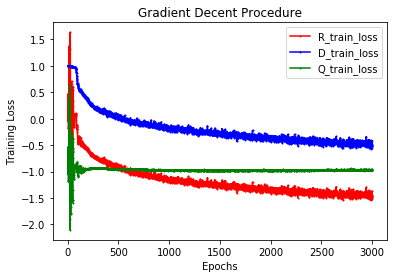

In [29]:
x1 = np.arange(args.nEpochs)+1
Rtrainloss = plt.plot(x1,R_loss_array,'ro-',label = 'R_train_loss', markersize=1)
Dtrainloss = plt.plot(x1,D_loss_array,'bo-',label = 'D_train_loss', markersize=1)
Qtrainloss = plt.plot(x1,Q_loss_array,'go-',label = 'Q_train_loss', markersize=1)
#plt.plot(x1,train_loss_array1,'r--',x1,test_loss_array1,'ro-')
plt.title('Gradient Decent Procedure')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
#plt.savefig('Three_variate_(32,32)ls1.svg')
plt.show()

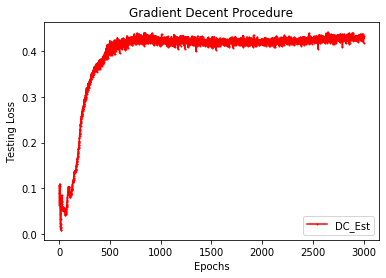

In [30]:
DCloss = plt.plot(x1,DC_loss_array,'ro-',label = 'DC_Est', markersize=1)
plt.title('Gradient Decent Procedure')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.legend()
#plt.savefig('Three_variate_(32,32)ls1.svg')
plt.show()

In [31]:
small_test_n = 1000
test_x = np.random.randn(small_test_n, p)
c = 5
test_truth1 = np.sin(np.pi *np.dot(test_x, b1)/2)
test_truth2 = np.sin(np.pi *np.dot(test_x, b2)/2)
sigma=0.25
test_eps1 = sigma*np.random.randn(small_test_n, 1)
test_eps2 = sigma*np.random.randn(small_test_n, 1)
test_y = np.sign(2*test_truth1+test_eps1)*np.log(np.abs(test_truth2+ c + test_eps2))

(1000, 2)
(480, 2)


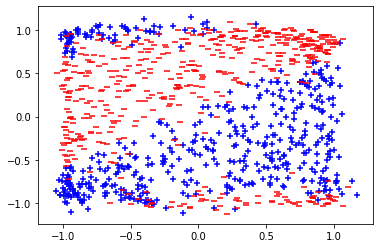

In [34]:
with torch.no_grad():
    X_test_t = torch.from_numpy(test_x).float()
    X_test_t = X_test_t.to(device)
    lant_t2s = R_net(X_test_t).cpu().numpy()
    print(lant_t2s.shape)
mirls_p_x = lant_t2s[np.where(test_y>=0)[0],]
mirls_n_x = lant_t2s[np.where(test_y<0)[0],]
plt.scatter(mirls_p_x[:,0], mirls_p_x[:,1], marker='+',color = 'blue')
plt.scatter(mirls_n_x[:,0], mirls_n_x[:,1], marker='_', color = 'red')
plt.savefig('MIDSRL_with_S.pdf')
plt.show()

In [35]:
x_test_s = np.random.randn(10000, p)
new_u = np.random.randn(10000, 1)
ref_diss = np.sin(np.pi *new_u/2)
with torch.no_grad():
    x_test_s = torch.from_numpy(x_test_s).float()
    x_test_s = x_test_s.to(device)
    lant_ts_dis = R_net(x_test_s).cpu().numpy()

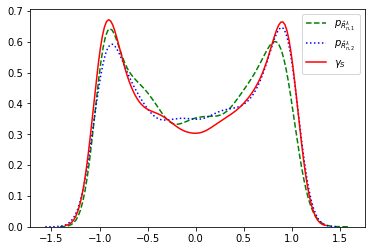

In [36]:
sns.distplot(lant_ts_dis[:,0],hist=False,label='$p_{\hat{R}^{\lambda}_{n,1}}$',kde_kws={'linestyle':'--'},color='green')
sns.distplot(lant_ts_dis[:,1],hist=False,label='$p_{\hat{R}^{\lambda}_{n,2}}$',kde_kws={'linestyle':':'},color='blue')
sns.distplot(ref_diss,hist=False,label='$\gamma_S$',kde=True,color='red')
plt.savefig('representation_density_sin.pdf')

# Uniform Ref-dis

In [38]:
U_train = np.random.uniform(size=(train_n, 2), low=0, high=1)
U_validation = np.random.uniform(size=(validation_n, 2), low=0, high=1)
U_test = np.random.uniform(size=(test_n, 2), low=0, high=1)

train_dat = TensorDataset(torch.from_numpy(y_train), torch.from_numpy(X_train).float(), torch.from_numpy(U_train).float())
trainLoader = DataLoader(train_dat, batch_size=args.batchSz, shuffle=True)
trainLoader_cor = DataLoader(train_dat, batch_size=len(train_dat), shuffle=False)

validation_dat = TensorDataset(torch.from_numpy(truth_validation), torch.from_numpy(X_validation).float(), torch.from_numpy(U_validation).float())
validationLoader = DataLoader(validation_dat, batch_size=len(validation_dat), shuffle=False)

test_dat = TensorDataset(torch.from_numpy(truth_test), torch.from_numpy(X_test).float(), torch.from_numpy(U_test).float())
testLoader = DataLoader(test_dat, batch_size=args.batchSz, shuffle=False)
testLoader_cor = DataLoader(test_dat, batch_size=len(test_dat), shuffle=False)

In [39]:
mylr = 1e-3
D_net = MIDiscriminator(u_dim, y_dim)
Q_net = PushDiscriminator(u_dim)
R_width_vec = [x_dim, 64, 64, 64,u_dim]
R_net = Representer(x_dim, u_dim, R_width_vec)
D_width_vec = [u_dim + y_dim, 32, 32] 
D_net = MIDiscriminator(u_dim, y_dim, D_width_vec)
Q_width_vec = [u_dim, 32, 32] 
Q_net = PushDiscriminator(u_dim, Q_width_vec)

In [40]:
args.nEpochs = 3000

In [41]:
print('  + Number of params (Rnet) : {}'.format(
    sum([p.data.nelement() for p in R_net.parameters()])))
print('  + Number of params (Dnet) : {}'.format(
    sum([p.data.nelement() for p in D_net.parameters()])))
print('  + Number of params (Qnet) : {}'.format(
    sum([p.data.nelement() for p in Q_net.parameters()])))
setup_seed(42, cuda_indicator)
R_net.apply(weight_init)
D_net.apply(weight_init)
Q_net.apply(weight_init)

if args.cuda:
    R_net = R_net.cuda()
    D_net = D_net.cuda()
    Q_net = Q_net.cuda()

optimizer_R = optim.Adam(R_net.parameters(), lr=mylr)
optimizer_D = optim.Adam(D_net.parameters(), lr=mylr)
optimizer_Q = optim.Adam(Q_net.parameters(), lr=mylr)

R_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
D_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
Q_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)
DC_loss_array = np.ndarray(shape=(args.nEpochs,1), dtype=float)

for epoch in range(1, args.nEpochs + 1):
    RLoss, DLoss, QLoss = train(trainLoader, trainLoader_cor, R_net, D_net, Q_net, optimizer_R, optimizer_D, optimizer_Q, device)
    R_loss_array[epoch-1] = RLoss
    D_loss_array[epoch-1] = DLoss
    Q_loss_array[epoch-1] = QLoss
    DC_loss_array[epoch-1] = test(R_net, validationLoader, device)
    with torch.no_grad():
        torch.cuda.empty_cache()    
        y_test_t, X_test_t, _ = next(iter(testLoader_cor))
        X_test_t, y_test_t = X_test_t.to(device), y_test_t.to(device)
        lant_t = R_net(X_test_t)
        print('DC:',cor(lant_t, y_test_t, X_test_t.shape[0], device).item())
        torch.cuda.empty_cache()

  + Number of params (Rnet) : 9160
  + Number of params (Dnet) : 1217
  + Number of params (Qnet) : 1185

Epoch 1: Test set: dCor_loss: 0.0108
DC: 0.015078502707183361

Epoch 2: Test set: dCor_loss: 0.0056
DC: 0.0057084280997514725

Epoch 3: Test set: dCor_loss: 0.0005
DC: 0.001202342682518065

Epoch 4: Test set: dCor_loss: 0.0005
DC: 0.0012984846252948046

Epoch 5: Test set: dCor_loss: 0.0006
DC: 0.0015269892755895853

Epoch 6: Test set: dCor_loss: 0.0007
DC: 0.0017030010931193829

Epoch 7: Test set: dCor_loss: 0.0008
DC: 0.0017920499667525291

Epoch 8: Test set: dCor_loss: 0.0015
DC: 0.002377288183197379

Epoch 9: Test set: dCor_loss: 0.0076
DC: 0.00840770173817873

Epoch 10: Test set: dCor_loss: 0.0102
DC: 0.015241920948028564

Epoch 11: Test set: dCor_loss: 0.0081
DC: 0.01367013156414032

Epoch 12: Test set: dCor_loss: 0.0067
DC: 0.012031289748847485

Epoch 13: Test set: dCor_loss: 0.0076
DC: 0.013271979056298733

Epoch 14: Test set: dCor_loss: 0.0104
DC: 0.01644802652299404

Epoch


Epoch 129: Test set: dCor_loss: 0.1005
DC: 0.09382999688386917

Epoch 130: Test set: dCor_loss: 0.1058
DC: 0.09748320281505585

Epoch 131: Test set: dCor_loss: 0.1073
DC: 0.09796196967363358

Epoch 132: Test set: dCor_loss: 0.1074
DC: 0.09784694761037827

Epoch 133: Test set: dCor_loss: 0.1076
DC: 0.09766121953725815

Epoch 134: Test set: dCor_loss: 0.1074
DC: 0.097532257437706

Epoch 135: Test set: dCor_loss: 0.1068
DC: 0.09740842133760452

Epoch 136: Test set: dCor_loss: 0.1070
DC: 0.09833139926195145

Epoch 137: Test set: dCor_loss: 0.1066
DC: 0.09836709499359131

Epoch 138: Test set: dCor_loss: 0.1052
DC: 0.09782164543867111

Epoch 139: Test set: dCor_loss: 0.1057
DC: 0.09943640232086182

Epoch 140: Test set: dCor_loss: 0.1058
DC: 0.10093526542186737

Epoch 141: Test set: dCor_loss: 0.1047
DC: 0.10040462762117386

Epoch 142: Test set: dCor_loss: 0.1036
DC: 0.09974045306444168

Epoch 143: Test set: dCor_loss: 0.1038
DC: 0.10015245527029037

Epoch 144: Test set: dCor_loss: 0.1060
DC


Epoch 258: Test set: dCor_loss: 0.2426
DC: 0.23948438465595245

Epoch 259: Test set: dCor_loss: 0.2411
DC: 0.23915846645832062

Epoch 260: Test set: dCor_loss: 0.2355
DC: 0.23426349461078644

Epoch 261: Test set: dCor_loss: 0.2401
DC: 0.2393122911453247

Epoch 262: Test set: dCor_loss: 0.2404
DC: 0.23927706480026245

Epoch 263: Test set: dCor_loss: 0.2395
DC: 0.24015162885189056

Epoch 264: Test set: dCor_loss: 0.2385
DC: 0.23890380561351776

Epoch 265: Test set: dCor_loss: 0.2409
DC: 0.24371643364429474

Epoch 266: Test set: dCor_loss: 0.2405
DC: 0.24641434848308563

Epoch 267: Test set: dCor_loss: 0.2386
DC: 0.24488310515880585

Epoch 268: Test set: dCor_loss: 0.2359
DC: 0.24525241553783417

Epoch 269: Test set: dCor_loss: 0.2346
DC: 0.24869492650032043

Epoch 270: Test set: dCor_loss: 0.2344
DC: 0.24572360515594482

Epoch 271: Test set: dCor_loss: 0.2353
DC: 0.24742120504379272

Epoch 272: Test set: dCor_loss: 0.2387
DC: 0.2538410723209381

Epoch 273: Test set: dCor_loss: 0.2386
DC


Epoch 388: Test set: dCor_loss: 0.3000
DC: 0.2988201379776001

Epoch 389: Test set: dCor_loss: 0.3083
DC: 0.3091530501842499

Epoch 390: Test set: dCor_loss: 0.3241
DC: 0.3216395378112793

Epoch 391: Test set: dCor_loss: 0.3251
DC: 0.32733628153800964

Epoch 392: Test set: dCor_loss: 0.3405
DC: 0.33975011110305786

Epoch 393: Test set: dCor_loss: 0.3331
DC: 0.33528774976730347

Epoch 394: Test set: dCor_loss: 0.3343
DC: 0.3323717713356018

Epoch 395: Test set: dCor_loss: 0.3345
DC: 0.3302663564682007

Epoch 396: Test set: dCor_loss: 0.3278
DC: 0.3276394009590149

Epoch 397: Test set: dCor_loss: 0.3184
DC: 0.31689825654029846

Epoch 398: Test set: dCor_loss: 0.3135
DC: 0.30953681468963623

Epoch 399: Test set: dCor_loss: 0.3112
DC: 0.31066441535949707

Epoch 400: Test set: dCor_loss: 0.2990
DC: 0.29994282126426697

Epoch 401: Test set: dCor_loss: 0.2935
DC: 0.29695987701416016

Epoch 402: Test set: dCor_loss: 0.2807
DC: 0.2794206142425537

Epoch 403: Test set: dCor_loss: 0.2838
DC: 0.2


Epoch 518: Test set: dCor_loss: 0.3301
DC: 0.3546965420246124

Epoch 519: Test set: dCor_loss: 0.3458
DC: 0.3737950325012207

Epoch 520: Test set: dCor_loss: 0.3488
DC: 0.37756261229515076

Epoch 521: Test set: dCor_loss: 0.3575
DC: 0.39085015654563904

Epoch 522: Test set: dCor_loss: 0.3801
DC: 0.41480767726898193

Epoch 523: Test set: dCor_loss: 0.3650
DC: 0.38844209909439087

Epoch 524: Test set: dCor_loss: 0.3133
DC: 0.32691314816474915

Epoch 525: Test set: dCor_loss: 0.2909
DC: 0.29131436347961426

Epoch 526: Test set: dCor_loss: 0.3088
DC: 0.31217920780181885

Epoch 527: Test set: dCor_loss: 0.3126
DC: 0.31776854395866394

Epoch 528: Test set: dCor_loss: 0.3112
DC: 0.31633496284484863

Epoch 529: Test set: dCor_loss: 0.3364
DC: 0.3473253846168518

Epoch 530: Test set: dCor_loss: 0.3465
DC: 0.3626348376274109

Epoch 531: Test set: dCor_loss: 0.3491
DC: 0.36549854278564453

Epoch 532: Test set: dCor_loss: 0.3438
DC: 0.36273181438446045

Epoch 533: Test set: dCor_loss: 0.3358
DC: 


Epoch 648: Test set: dCor_loss: 0.3440
DC: 0.35017189383506775

Epoch 649: Test set: dCor_loss: 0.3376
DC: 0.3424963057041168

Epoch 650: Test set: dCor_loss: 0.3513
DC: 0.3605063855648041

Epoch 651: Test set: dCor_loss: 0.3544
DC: 0.3630371391773224

Epoch 652: Test set: dCor_loss: 0.3534
DC: 0.3646363615989685

Epoch 653: Test set: dCor_loss: 0.3608
DC: 0.37345245480537415

Epoch 654: Test set: dCor_loss: 0.3546
DC: 0.36589547991752625

Epoch 655: Test set: dCor_loss: 0.3667
DC: 0.3826662003993988

Epoch 656: Test set: dCor_loss: 0.3635
DC: 0.3805272579193115

Epoch 657: Test set: dCor_loss: 0.3702
DC: 0.3872760832309723

Epoch 658: Test set: dCor_loss: 0.3618
DC: 0.3795098066329956

Epoch 659: Test set: dCor_loss: 0.3421
DC: 0.35414886474609375

Epoch 660: Test set: dCor_loss: 0.3442
DC: 0.3620753586292267

Epoch 661: Test set: dCor_loss: 0.3315
DC: 0.34592127799987793

Epoch 662: Test set: dCor_loss: 0.3264
DC: 0.34205368161201477

Epoch 663: Test set: dCor_loss: 0.3232
DC: 0.337


Epoch 778: Test set: dCor_loss: 0.3566
DC: 0.36752939224243164

Epoch 779: Test set: dCor_loss: 0.3722
DC: 0.38168179988861084

Epoch 780: Test set: dCor_loss: 0.3815
DC: 0.39121681451797485

Epoch 781: Test set: dCor_loss: 0.3937
DC: 0.40668243169784546

Epoch 782: Test set: dCor_loss: 0.4081
DC: 0.42395398020744324

Epoch 783: Test set: dCor_loss: 0.4075
DC: 0.42752382159233093

Epoch 784: Test set: dCor_loss: 0.4201
DC: 0.444241464138031

Epoch 785: Test set: dCor_loss: 0.4176
DC: 0.4415079951286316

Epoch 786: Test set: dCor_loss: 0.4102
DC: 0.43154704570770264

Epoch 787: Test set: dCor_loss: 0.4106
DC: 0.4313131272792816

Epoch 788: Test set: dCor_loss: 0.4000
DC: 0.4229256212711334

Epoch 789: Test set: dCor_loss: 0.3560
DC: 0.3759077191352844

Epoch 790: Test set: dCor_loss: 0.3596
DC: 0.37502506375312805

Epoch 791: Test set: dCor_loss: 0.3719
DC: 0.3848514258861542

Epoch 792: Test set: dCor_loss: 0.3659
DC: 0.37845179438591003

Epoch 793: Test set: dCor_loss: 0.3682
DC: 0.3


Epoch 908: Test set: dCor_loss: 0.4794
DC: 0.4915144741535187

Epoch 909: Test set: dCor_loss: 0.4871
DC: 0.4981893301010132

Epoch 910: Test set: dCor_loss: 0.4923
DC: 0.5044172406196594

Epoch 911: Test set: dCor_loss: 0.5198
DC: 0.5308900475502014

Epoch 912: Test set: dCor_loss: 0.5316
DC: 0.5514886975288391

Epoch 913: Test set: dCor_loss: 0.4289
DC: 0.44099366664886475

Epoch 914: Test set: dCor_loss: 0.3337
DC: 0.34836727380752563

Epoch 915: Test set: dCor_loss: 0.3816
DC: 0.3860240578651428

Epoch 916: Test set: dCor_loss: 0.3934
DC: 0.3938658535480499

Epoch 917: Test set: dCor_loss: 0.4126
DC: 0.4213971197605133

Epoch 918: Test set: dCor_loss: 0.4270
DC: 0.4359985888004303

Epoch 919: Test set: dCor_loss: 0.4241
DC: 0.4326227903366089

Epoch 920: Test set: dCor_loss: 0.4369
DC: 0.44622430205345154

Epoch 921: Test set: dCor_loss: 0.4270
DC: 0.4344196617603302

Epoch 922: Test set: dCor_loss: 0.4593
DC: 0.46789243817329407

Epoch 923: Test set: dCor_loss: 0.4589
DC: 0.46862


Epoch 1038: Test set: dCor_loss: 0.5254
DC: 0.5310741066932678

Epoch 1039: Test set: dCor_loss: 0.5307
DC: 0.5419886708259583

Epoch 1040: Test set: dCor_loss: 0.5256
DC: 0.5336108803749084

Epoch 1041: Test set: dCor_loss: 0.5499
DC: 0.5579521656036377

Epoch 1042: Test set: dCor_loss: 0.5808
DC: 0.5876010656356812

Epoch 1043: Test set: dCor_loss: 0.5674
DC: 0.5681629776954651

Epoch 1044: Test set: dCor_loss: 0.5647
DC: 0.5672980546951294

Epoch 1045: Test set: dCor_loss: 0.5535
DC: 0.5533913969993591

Epoch 1046: Test set: dCor_loss: 0.5445
DC: 0.5469896793365479

Epoch 1047: Test set: dCor_loss: 0.5289
DC: 0.5327542424201965

Epoch 1048: Test set: dCor_loss: 0.5355
DC: 0.537382185459137

Epoch 1049: Test set: dCor_loss: 0.5490
DC: 0.554670512676239

Epoch 1050: Test set: dCor_loss: 0.5727
DC: 0.580299973487854

Epoch 1051: Test set: dCor_loss: 0.5856
DC: 0.590607762336731

Epoch 1052: Test set: dCor_loss: 0.5979
DC: 0.6065444350242615

Epoch 1053: Test set: dCor_loss: 0.6010
DC:


Epoch 1167: Test set: dCor_loss: 0.5338
DC: 0.5439879894256592

Epoch 1168: Test set: dCor_loss: 0.5438
DC: 0.5539330840110779

Epoch 1169: Test set: dCor_loss: 0.5541
DC: 0.5585278272628784

Epoch 1170: Test set: dCor_loss: 0.5561
DC: 0.5554535388946533

Epoch 1171: Test set: dCor_loss: 0.5602
DC: 0.5624241828918457

Epoch 1172: Test set: dCor_loss: 0.5540
DC: 0.5581658482551575

Epoch 1173: Test set: dCor_loss: 0.5728
DC: 0.5718659162521362

Epoch 1174: Test set: dCor_loss: 0.5667
DC: 0.5661747455596924

Epoch 1175: Test set: dCor_loss: 0.5451
DC: 0.5420153737068176

Epoch 1176: Test set: dCor_loss: 0.5401
DC: 0.5357428193092346

Epoch 1177: Test set: dCor_loss: 0.5420
DC: 0.5403701663017273

Epoch 1178: Test set: dCor_loss: 0.5317
DC: 0.5295959711074829

Epoch 1179: Test set: dCor_loss: 0.5593
DC: 0.5616511702537537

Epoch 1180: Test set: dCor_loss: 0.5897
DC: 0.5922598242759705

Epoch 1181: Test set: dCor_loss: 0.6126
DC: 0.6224628686904907

Epoch 1182: Test set: dCor_loss: 0.5601


Epoch 1296: Test set: dCor_loss: 0.4971
DC: 0.5100528001785278

Epoch 1297: Test set: dCor_loss: 0.5074
DC: 0.5201143026351929

Epoch 1298: Test set: dCor_loss: 0.4937
DC: 0.5066031217575073

Epoch 1299: Test set: dCor_loss: 0.4868
DC: 0.4999419152736664

Epoch 1300: Test set: dCor_loss: 0.5047
DC: 0.5183963179588318

Epoch 1301: Test set: dCor_loss: 0.5001
DC: 0.510949969291687

Epoch 1302: Test set: dCor_loss: 0.4862
DC: 0.5030402541160583

Epoch 1303: Test set: dCor_loss: 0.5019
DC: 0.5140287280082703

Epoch 1304: Test set: dCor_loss: 0.4944
DC: 0.5054418444633484

Epoch 1305: Test set: dCor_loss: 0.4962
DC: 0.5130882263183594

Epoch 1306: Test set: dCor_loss: 0.4937
DC: 0.5133070349693298

Epoch 1307: Test set: dCor_loss: 0.5018
DC: 0.5192935466766357

Epoch 1308: Test set: dCor_loss: 0.5151
DC: 0.529005229473114

Epoch 1309: Test set: dCor_loss: 0.5032
DC: 0.5171484351158142

Epoch 1310: Test set: dCor_loss: 0.4894
DC: 0.503001868724823

Epoch 1311: Test set: dCor_loss: 0.4949
DC


Epoch 1425: Test set: dCor_loss: 0.4884
DC: 0.5052124261856079

Epoch 1426: Test set: dCor_loss: 0.4886
DC: 0.5052855610847473

Epoch 1427: Test set: dCor_loss: 0.4783
DC: 0.49395978450775146

Epoch 1428: Test set: dCor_loss: 0.4767
DC: 0.49316486716270447

Epoch 1429: Test set: dCor_loss: 0.4915
DC: 0.5060446262359619

Epoch 1430: Test set: dCor_loss: 0.4930
DC: 0.5069468021392822

Epoch 1431: Test set: dCor_loss: 0.4889
DC: 0.5057510137557983

Epoch 1432: Test set: dCor_loss: 0.4931
DC: 0.5136756300926208

Epoch 1433: Test set: dCor_loss: 0.4976
DC: 0.5114442110061646

Epoch 1434: Test set: dCor_loss: 0.4795
DC: 0.4933071732521057

Epoch 1435: Test set: dCor_loss: 0.4845
DC: 0.49999672174453735

Epoch 1436: Test set: dCor_loss: 0.4863
DC: 0.5026189684867859

Epoch 1437: Test set: dCor_loss: 0.4867
DC: 0.5061880350112915

Epoch 1438: Test set: dCor_loss: 0.4793
DC: 0.4954988658428192

Epoch 1439: Test set: dCor_loss: 0.4832
DC: 0.499370276927948

Epoch 1440: Test set: dCor_loss: 0.50


Epoch 1553: Test set: dCor_loss: 0.5036
DC: 0.5175666809082031

Epoch 1554: Test set: dCor_loss: 0.4906
DC: 0.5040628910064697

Epoch 1555: Test set: dCor_loss: 0.4783
DC: 0.4957472085952759

Epoch 1556: Test set: dCor_loss: 0.5005
DC: 0.5147416591644287

Epoch 1557: Test set: dCor_loss: 0.5029
DC: 0.5154480934143066

Epoch 1558: Test set: dCor_loss: 0.4855
DC: 0.5006198287010193

Epoch 1559: Test set: dCor_loss: 0.4719
DC: 0.4847295880317688

Epoch 1560: Test set: dCor_loss: 0.5069
DC: 0.52144855260849

Epoch 1561: Test set: dCor_loss: 0.4863
DC: 0.5001141428947449

Epoch 1562: Test set: dCor_loss: 0.4924
DC: 0.5061913728713989

Epoch 1563: Test set: dCor_loss: 0.5067
DC: 0.5208673477172852

Epoch 1564: Test set: dCor_loss: 0.4926
DC: 0.5042780041694641

Epoch 1565: Test set: dCor_loss: 0.4797
DC: 0.4937571585178375

Epoch 1566: Test set: dCor_loss: 0.5040
DC: 0.5186682939529419

Epoch 1567: Test set: dCor_loss: 0.5040
DC: 0.5170460939407349

Epoch 1568: Test set: dCor_loss: 0.4894
D


Epoch 1682: Test set: dCor_loss: 0.4943
DC: 0.5076860189437866

Epoch 1683: Test set: dCor_loss: 0.5082
DC: 0.5195757150650024

Epoch 1684: Test set: dCor_loss: 0.4999
DC: 0.5146241784095764

Epoch 1685: Test set: dCor_loss: 0.4983
DC: 0.5181415677070618

Epoch 1686: Test set: dCor_loss: 0.4922
DC: 0.5072401762008667

Epoch 1687: Test set: dCor_loss: 0.4995
DC: 0.5150112509727478

Epoch 1688: Test set: dCor_loss: 0.4990
DC: 0.511282205581665

Epoch 1689: Test set: dCor_loss: 0.4852
DC: 0.49884501099586487

Epoch 1690: Test set: dCor_loss: 0.4974
DC: 0.509964108467102

Epoch 1691: Test set: dCor_loss: 0.5024
DC: 0.514333963394165

Epoch 1692: Test set: dCor_loss: 0.4994
DC: 0.5087470412254333

Epoch 1693: Test set: dCor_loss: 0.5009
DC: 0.5161949992179871

Epoch 1694: Test set: dCor_loss: 0.4996
DC: 0.519023597240448

Epoch 1695: Test set: dCor_loss: 0.4987
DC: 0.5130084156990051

Epoch 1696: Test set: dCor_loss: 0.5015
DC: 0.514946699142456

Epoch 1697: Test set: dCor_loss: 0.5034
DC:


Epoch 1811: Test set: dCor_loss: 0.5095
DC: 0.5228328108787537

Epoch 1812: Test set: dCor_loss: 0.4992
DC: 0.5091220736503601

Epoch 1813: Test set: dCor_loss: 0.5005
DC: 0.5139546990394592

Epoch 1814: Test set: dCor_loss: 0.4997
DC: 0.513920247554779

Epoch 1815: Test set: dCor_loss: 0.5093
DC: 0.5215161442756653

Epoch 1816: Test set: dCor_loss: 0.4892
DC: 0.5024404525756836

Epoch 1817: Test set: dCor_loss: 0.4973
DC: 0.511366605758667

Epoch 1818: Test set: dCor_loss: 0.5093
DC: 0.5218241214752197

Epoch 1819: Test set: dCor_loss: 0.4910
DC: 0.503358781337738

Epoch 1820: Test set: dCor_loss: 0.4992
DC: 0.5120750665664673

Epoch 1821: Test set: dCor_loss: 0.5057
DC: 0.5204756259918213

Epoch 1822: Test set: dCor_loss: 0.5143
DC: 0.5291909575462341

Epoch 1823: Test set: dCor_loss: 0.5093
DC: 0.5237661004066467

Epoch 1824: Test set: dCor_loss: 0.4851
DC: 0.5008278489112854

Epoch 1825: Test set: dCor_loss: 0.5074
DC: 0.5211506485939026

Epoch 1826: Test set: dCor_loss: 0.5129
DC


Epoch 1940: Test set: dCor_loss: 0.5051
DC: 0.5180851817131042

Epoch 1941: Test set: dCor_loss: 0.5098
DC: 0.5288240909576416

Epoch 1942: Test set: dCor_loss: 0.4946
DC: 0.5051097273826599

Epoch 1943: Test set: dCor_loss: 0.4996
DC: 0.5135825276374817

Epoch 1944: Test set: dCor_loss: 0.5157
DC: 0.5328565239906311

Epoch 1945: Test set: dCor_loss: 0.4989
DC: 0.5156990885734558

Epoch 1946: Test set: dCor_loss: 0.4861
DC: 0.5062611103057861

Epoch 1947: Test set: dCor_loss: 0.5010
DC: 0.5163699984550476

Epoch 1948: Test set: dCor_loss: 0.4969
DC: 0.511164665222168

Epoch 1949: Test set: dCor_loss: 0.5160
DC: 0.5277181267738342

Epoch 1950: Test set: dCor_loss: 0.5236
DC: 0.5387988090515137

Epoch 1951: Test set: dCor_loss: 0.4983
DC: 0.514559805393219

Epoch 1952: Test set: dCor_loss: 0.4887
DC: 0.5075346231460571

Epoch 1953: Test set: dCor_loss: 0.5042
DC: 0.5155168771743774

Epoch 1954: Test set: dCor_loss: 0.5092
DC: 0.5246780514717102

Epoch 1955: Test set: dCor_loss: 0.5026
D


Epoch 2069: Test set: dCor_loss: 0.5227
DC: 0.5383918285369873

Epoch 2070: Test set: dCor_loss: 0.5087
DC: 0.5264310836791992

Epoch 2071: Test set: dCor_loss: 0.5011
DC: 0.5197678208351135

Epoch 2072: Test set: dCor_loss: 0.5207
DC: 0.537776529788971

Epoch 2073: Test set: dCor_loss: 0.5147
DC: 0.5276699066162109

Epoch 2074: Test set: dCor_loss: 0.5216
DC: 0.5399636626243591

Epoch 2075: Test set: dCor_loss: 0.4918
DC: 0.5097046494483948

Epoch 2076: Test set: dCor_loss: 0.4846
DC: 0.5002270936965942

Epoch 2077: Test set: dCor_loss: 0.5064
DC: 0.5224482417106628

Epoch 2078: Test set: dCor_loss: 0.5102
DC: 0.5242312550544739

Epoch 2079: Test set: dCor_loss: 0.5113
DC: 0.529026210308075

Epoch 2080: Test set: dCor_loss: 0.5149
DC: 0.5321232080459595

Epoch 2081: Test set: dCor_loss: 0.5121
DC: 0.5285091996192932

Epoch 2082: Test set: dCor_loss: 0.5070
DC: 0.5210319757461548

Epoch 2083: Test set: dCor_loss: 0.5103
DC: 0.5252873301506042

Epoch 2084: Test set: dCor_loss: 0.5046
D


Epoch 2198: Test set: dCor_loss: 0.4929
DC: 0.5123295187950134

Epoch 2199: Test set: dCor_loss: 0.5193
DC: 0.5423237681388855

Epoch 2200: Test set: dCor_loss: 0.4980
DC: 0.5114142298698425

Epoch 2201: Test set: dCor_loss: 0.5143
DC: 0.5336079597473145

Epoch 2202: Test set: dCor_loss: 0.5132
DC: 0.5333266854286194

Epoch 2203: Test set: dCor_loss: 0.5052
DC: 0.5248708128929138

Epoch 2204: Test set: dCor_loss: 0.5004
DC: 0.5225104093551636

Epoch 2205: Test set: dCor_loss: 0.4978
DC: 0.5189170241355896

Epoch 2206: Test set: dCor_loss: 0.4954
DC: 0.5140532851219177

Epoch 2207: Test set: dCor_loss: 0.5143
DC: 0.5363637208938599

Epoch 2208: Test set: dCor_loss: 0.5058
DC: 0.5276954770088196

Epoch 2209: Test set: dCor_loss: 0.5076
DC: 0.5276448726654053

Epoch 2210: Test set: dCor_loss: 0.5152
DC: 0.5354999303817749

Epoch 2211: Test set: dCor_loss: 0.5000
DC: 0.5184606313705444

Epoch 2212: Test set: dCor_loss: 0.5171
DC: 0.5375567078590393

Epoch 2213: Test set: dCor_loss: 0.5143


Epoch 2327: Test set: dCor_loss: 0.4961
DC: 0.5169623494148254

Epoch 2328: Test set: dCor_loss: 0.5128
DC: 0.5334188342094421

Epoch 2329: Test set: dCor_loss: 0.4901
DC: 0.5114275217056274

Epoch 2330: Test set: dCor_loss: 0.4870
DC: 0.5055575370788574

Epoch 2331: Test set: dCor_loss: 0.5138
DC: 0.5319856405258179

Epoch 2332: Test set: dCor_loss: 0.5195
DC: 0.5400053858757019

Epoch 2333: Test set: dCor_loss: 0.5106
DC: 0.5306411385536194

Epoch 2334: Test set: dCor_loss: 0.5087
DC: 0.5321341156959534

Epoch 2335: Test set: dCor_loss: 0.5077
DC: 0.527747631072998

Epoch 2336: Test set: dCor_loss: 0.5217
DC: 0.5413821935653687

Epoch 2337: Test set: dCor_loss: 0.5177
DC: 0.5372630953788757

Epoch 2338: Test set: dCor_loss: 0.5230
DC: 0.5453081130981445

Epoch 2339: Test set: dCor_loss: 0.4906
DC: 0.5132052898406982

Epoch 2340: Test set: dCor_loss: 0.4938
DC: 0.5159978866577148

Epoch 2341: Test set: dCor_loss: 0.5054
DC: 0.523985743522644

Epoch 2342: Test set: dCor_loss: 0.5143
D


Epoch 2456: Test set: dCor_loss: 0.4989
DC: 0.5196648240089417

Epoch 2457: Test set: dCor_loss: 0.5073
DC: 0.5354747176170349

Epoch 2458: Test set: dCor_loss: 0.5014
DC: 0.5261439681053162

Epoch 2459: Test set: dCor_loss: 0.4982
DC: 0.5208736062049866

Epoch 2460: Test set: dCor_loss: 0.5074
DC: 0.5303061604499817

Epoch 2461: Test set: dCor_loss: 0.5147
DC: 0.5369104743003845

Epoch 2462: Test set: dCor_loss: 0.5071
DC: 0.5292103290557861

Epoch 2463: Test set: dCor_loss: 0.5021
DC: 0.5247982740402222

Epoch 2464: Test set: dCor_loss: 0.5059
DC: 0.5329892635345459

Epoch 2465: Test set: dCor_loss: 0.5101
DC: 0.5325325131416321

Epoch 2466: Test set: dCor_loss: 0.5075
DC: 0.5323939919471741

Epoch 2467: Test set: dCor_loss: 0.5026
DC: 0.5248996615409851

Epoch 2468: Test set: dCor_loss: 0.5088
DC: 0.5308219790458679

Epoch 2469: Test set: dCor_loss: 0.5075
DC: 0.5303117632865906

Epoch 2470: Test set: dCor_loss: 0.5093
DC: 0.5333651900291443

Epoch 2471: Test set: dCor_loss: 0.5133


Epoch 2585: Test set: dCor_loss: 0.5148
DC: 0.5363414287567139

Epoch 2586: Test set: dCor_loss: 0.5067
DC: 0.5283301472663879

Epoch 2587: Test set: dCor_loss: 0.5121
DC: 0.5340270400047302

Epoch 2588: Test set: dCor_loss: 0.4947
DC: 0.51995450258255

Epoch 2589: Test set: dCor_loss: 0.5102
DC: 0.5344802737236023

Epoch 2590: Test set: dCor_loss: 0.5162
DC: 0.5360434055328369

Epoch 2591: Test set: dCor_loss: 0.5085
DC: 0.5346278548240662

Epoch 2592: Test set: dCor_loss: 0.5140
DC: 0.5366477966308594

Epoch 2593: Test set: dCor_loss: 0.5051
DC: 0.5307435393333435

Epoch 2594: Test set: dCor_loss: 0.5174
DC: 0.5431963205337524

Epoch 2595: Test set: dCor_loss: 0.4974
DC: 0.522068977355957

Epoch 2596: Test set: dCor_loss: 0.5015
DC: 0.5302651524543762

Epoch 2597: Test set: dCor_loss: 0.4905
DC: 0.5139777660369873

Epoch 2598: Test set: dCor_loss: 0.4942
DC: 0.522304117679596

Epoch 2599: Test set: dCor_loss: 0.5286
DC: 0.5505201816558838

Epoch 2600: Test set: dCor_loss: 0.5147
DC:


Epoch 2714: Test set: dCor_loss: 0.5032
DC: 0.5246443152427673

Epoch 2715: Test set: dCor_loss: 0.4989
DC: 0.522925853729248

Epoch 2716: Test set: dCor_loss: 0.4893
DC: 0.5126067399978638

Epoch 2717: Test set: dCor_loss: 0.5167
DC: 0.5405353307723999

Epoch 2718: Test set: dCor_loss: 0.4953
DC: 0.5198274254798889

Epoch 2719: Test set: dCor_loss: 0.5110
DC: 0.5341127514839172

Epoch 2720: Test set: dCor_loss: 0.5075
DC: 0.5298091769218445

Epoch 2721: Test set: dCor_loss: 0.4940
DC: 0.5198023319244385

Epoch 2722: Test set: dCor_loss: 0.5133
DC: 0.5393022894859314

Epoch 2723: Test set: dCor_loss: 0.5083
DC: 0.5353901386260986

Epoch 2724: Test set: dCor_loss: 0.5231
DC: 0.5496113896369934

Epoch 2725: Test set: dCor_loss: 0.5053
DC: 0.5323994755744934

Epoch 2726: Test set: dCor_loss: 0.4971
DC: 0.5253725051879883

Epoch 2727: Test set: dCor_loss: 0.5048
DC: 0.5316070914268494

Epoch 2728: Test set: dCor_loss: 0.5045
DC: 0.5313207507133484

Epoch 2729: Test set: dCor_loss: 0.5187



Epoch 2843: Test set: dCor_loss: 0.4959
DC: 0.5218083262443542

Epoch 2844: Test set: dCor_loss: 0.5298
DC: 0.5535506010055542

Epoch 2845: Test set: dCor_loss: 0.5110
DC: 0.5322758555412292

Epoch 2846: Test set: dCor_loss: 0.4986
DC: 0.5280935764312744

Epoch 2847: Test set: dCor_loss: 0.5124
DC: 0.5384716391563416

Epoch 2848: Test set: dCor_loss: 0.4900
DC: 0.5174586772918701

Epoch 2849: Test set: dCor_loss: 0.5073
DC: 0.533783495426178

Epoch 2850: Test set: dCor_loss: 0.5092
DC: 0.5375483632087708

Epoch 2851: Test set: dCor_loss: 0.5097
DC: 0.5353884100914001

Epoch 2852: Test set: dCor_loss: 0.5146
DC: 0.5412157773971558

Epoch 2853: Test set: dCor_loss: 0.5091
DC: 0.5361434817314148

Epoch 2854: Test set: dCor_loss: 0.5139
DC: 0.5412213206291199

Epoch 2855: Test set: dCor_loss: 0.5169
DC: 0.5430142283439636

Epoch 2856: Test set: dCor_loss: 0.5167
DC: 0.5409865975379944

Epoch 2857: Test set: dCor_loss: 0.5062
DC: 0.5324277281761169

Epoch 2858: Test set: dCor_loss: 0.5018



Epoch 2972: Test set: dCor_loss: 0.4995
DC: 0.5294718146324158

Epoch 2973: Test set: dCor_loss: 0.4841
DC: 0.5136052370071411

Epoch 2974: Test set: dCor_loss: 0.4991
DC: 0.5254149436950684

Epoch 2975: Test set: dCor_loss: 0.4970
DC: 0.5216014981269836

Epoch 2976: Test set: dCor_loss: 0.5031
DC: 0.5275967121124268

Epoch 2977: Test set: dCor_loss: 0.4974
DC: 0.5241058468818665

Epoch 2978: Test set: dCor_loss: 0.4974
DC: 0.5264074206352234

Epoch 2979: Test set: dCor_loss: 0.5072
DC: 0.5356648564338684

Epoch 2980: Test set: dCor_loss: 0.4979
DC: 0.5261721611022949

Epoch 2981: Test set: dCor_loss: 0.5158
DC: 0.5435299277305603

Epoch 2982: Test set: dCor_loss: 0.5171
DC: 0.5465209484100342

Epoch 2983: Test set: dCor_loss: 0.5108
DC: 0.5376502275466919

Epoch 2984: Test set: dCor_loss: 0.5096
DC: 0.5422738194465637

Epoch 2985: Test set: dCor_loss: 0.5063
DC: 0.530562162399292

Epoch 2986: Test set: dCor_loss: 0.5195
DC: 0.5435231328010559

Epoch 2987: Test set: dCor_loss: 0.4930


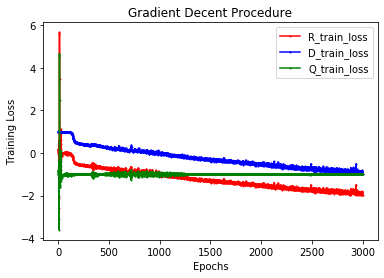

In [42]:
x1 = np.arange(args.nEpochs)+1
Rtrainloss = plt.plot(x1,R_loss_array,'ro-',label = 'R_train_loss', markersize=1)
Dtrainloss = plt.plot(x1,D_loss_array,'bo-',label = 'D_train_loss', markersize=1)
Qtrainloss = plt.plot(x1,Q_loss_array,'go-',label = 'Q_train_loss', markersize=1)
plt.title('Gradient Decent Procedure')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

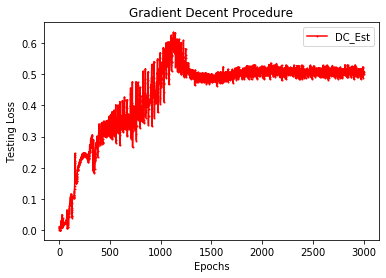

In [43]:
DCloss = plt.plot(x1,DC_loss_array,'ro-',label = 'DC_Est', markersize=1)
plt.title('Gradient Decent Procedure')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.legend()
plt.show()

In [44]:
with torch.no_grad():
    X_test_t = torch.from_numpy(test_x).float()
    X_test_t = X_test_t.to(device)
    lant_t2u = R_net(X_test_t).cpu().numpy()
    print(lant_t2u.shape)
mirlu_p_x = lant_t2u[np.where(test_y>=0)[0],]
print(mirlu_p_x.shape)
mirlu_n_x = lant_t2u[np.where(test_y<0)[0],]

(1000, 2)
(480, 2)


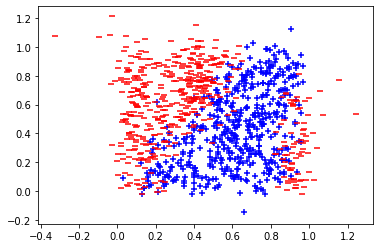

In [52]:
plt.scatter(mirlu_p_x[:,0], mirlu_p_x[:,1], marker='+',color = 'blue')
plt.scatter(mirlu_n_x[:,0], mirlu_n_x[:,1], marker='_', color = 'red')
plt.savefig('MIDSRL_with_U.pdf')
plt.show()

In [46]:
x_test_u = np.random.randn(10000, p)
ref_disu = np.random.uniform(size=(10000, 1), low=0, high=1)
with torch.no_grad():
    x_test_u = torch.from_numpy(x_test_u).float()
    x_test_u = x_test_u.to(device)
    lant_tu_dis = R_net(x_test_u).cpu().numpy()

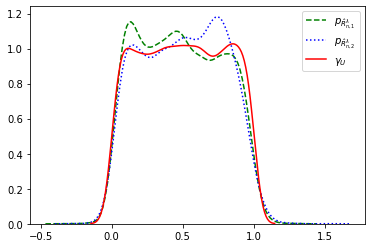

In [53]:
sns.distplot(lant_tu_dis[:,0],hist=False,label='$p_{\hat{R}^{\lambda}_{n,1}}$',kde_kws={'linestyle':'--'},color='green')
sns.distplot(lant_tu_dis[:,1],hist=False,label='$p_{\hat{R}^{\lambda}_{n,2}}$',kde_kws={'linestyle':':'},color='blue')
sns.distplot(ref_disu,hist=False,label='$\gamma_U$',kde=True,color='red')
plt.savefig('representation_density_unif.pdf')

# GSIR

In [48]:
ytype = 'scalar'
atype = 'identity'
ex, rho_x = 1e-3, 1
ey, rho_y = 1e-3, 1
pred_test = gsir(X_train, test_x, y_train, ytype, atype, ex, ey, rho_x, rho_y, args.latent_dim)
pred_test1 = np.array(pred_test)
gsir_p_x = pred_test1[np.where(test_y>=0)[0],]
gsir_n_x = pred_test1[np.where(test_y<0)[0],]

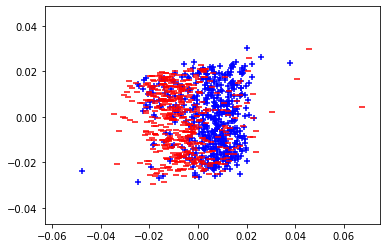

In [49]:
plt.scatter(gsir_p_x[:,0], gsir_p_x[:,1], marker='+',color = 'blue')
plt.scatter(gsir_n_x[:,0], gsir_n_x[:,1], marker='_', color = 'red')
# plt.title('GSIR')
# plt.xticks([])
# plt.yticks([])
# plt.legend()
plt.savefig('GSIR.pdf')
plt.show()

# GSAVE

In [50]:
pred_test = gsave(X_train, test_x, y_train, ytype, ex, ey, rho_x, rho_y, args.latent_dim)
pred_test1 = np.array(pred_test)
gsave_p_x = pred_test1[np.where(test_y>=0)[0],]
gsave_n_x = pred_test1[np.where(test_y<0)[0],]

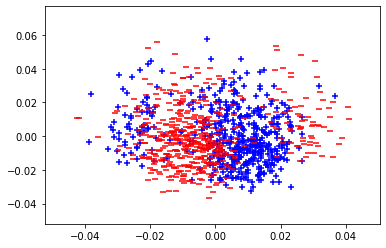

In [51]:
plt.scatter(gsave_p_x[:,0], gsave_p_x[:,1], marker='+',color = 'blue')
plt.scatter(gsave_n_x[:,0], gsave_n_x[:,1], marker='_', color = 'red')
plt.savefig('GSAVE.pdf')
plt.show()

# SIR

In [294]:
sn = 15
pred_test = sir_sdr(X_train, test_x, y_train, sn, ytype, args.latent_dim)
pred_test1 = np.array(pred_test)

(480, 2)


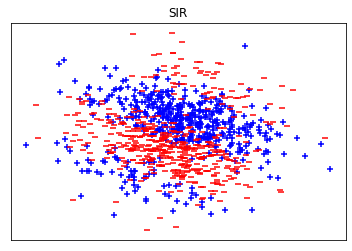

In [295]:
sir_p_x = pred_test1[np.where(test_y>=0)[0],]
sir_n_x = pred_test1[np.where(test_y<0)[0],]
plt.scatter(sir_p_x[:,0], sir_p_x[:,1], marker='+',color = 'blue')
plt.scatter(sir_n_x[:,0], sir_n_x[:,1], marker='_', color = 'red')
plt.title('SIR')
plt.show()

# SAVE

In [282]:
pred_test = save_sdr(X_train, test_x, y_train, sn, ytype, args.latent_dim)
pred_test1 = np.array(pred_test)

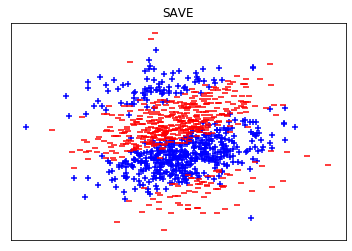

In [283]:
save_p_x = pred_test1[np.where(test_y>=0)[0],]
save_n_x = pred_test1[np.where(test_y<0)[0],]
plt.scatter(save_p_x[:,0], save_p_x[:,1], marker='+',color = 'blue')
plt.scatter(save_n_x[:,0], save_n_x[:,1], marker='_', color = 'red')
plt.title('SAVE')
plt.show()